In [1]:
import pandas as pd
import yfinance as yf
import quantstats as qs


# High Yield Spread

In [2]:
from fredapi import Fred

# 設定 API Key
api_key = '8ab5c621a48fd00a1360158a99f0848b'
fred = Fred(api_key=api_key)
data1 = fred.get_series('DBAA')
data2 = fred.get_series('DGS10')  # Moody's Seasoned Baa Corporate Bond Yield # 美國十年期公債殖利率
rolling_years = 10

tmp = (data1-data2).dropna().ewm(span = 252*rolling_years, min_periods = 252*rolling_years ).mean() #span: rolling days
df = pd.DataFrame((data1-data2), columns=['HYS'])
df['10year_EMA'] = tmp
df = df.shift(2)



In [3]:
data2

1962-01-02    4.06
1962-01-03    4.03
1962-01-04    3.99
1962-01-05    4.02
1962-01-08    4.03
              ... 
2025-01-03    4.60
2025-01-06    4.62
2025-01-07    4.67
2025-01-08    4.67
2025-01-09    4.68
Length: 16443, dtype: float64

In [4]:
'''Peaks and troughs'''
month = 90
peak = df['HYS'].min()
peaks = []
l_peak = []
l_peaks = 0
trough = df['HYS'].max()
troughs = []
for _,row in df.iterrows():
    if row['HYS'] > row['10year_EMA'] and row['HYS'] > peak:
        peak = row['HYS']
        thorugh = df['HYS'].max()
        peaks.append(peak)
        troughs.append(trough)
    elif row['HYS'] < row['10year_EMA'] and row['HYS'] < trough:
        peak = df['HYS'].min()
        trough = row['HYS']
        peaks.append(peak)
        troughs.append(trough)
    else:
        peaks.append(peak)
        troughs.append(trough)

df['peak'] = peaks
df['trough'] = troughs
df['slope'] = df['HYS'].pct_change(month)
df = df.dropna()



In [5]:
conditions = []
condition = 0
targets = []
target = 0

for _,row in df.iterrows():
    if   row['HYS'] > row['10year_EMA'] and row['slope'] > 0:
        condition = ['Decline']
        target = ['XLP']
    elif row['HYS'] > row['10year_EMA'] and row['slope'] < 0:
        condition = ['Recovery']
        target = ['XLY','XLB']
    elif row['HYS'] < row['10year_EMA'] and row['slope'] > 0:
        condition = ['Early']
        target = ['XLF','XLE','XLI']
    elif row['HYS'] < row['10year_EMA'] and row['slope'] < 0:
        condition = ['Late']
        target = ['XLK','XLV']
   
    else:
        condition = condition
        target = target

    conditions.append(condition)
    targets.append(target)

df['condition'] = conditions
df['targets'] = targets



In [6]:
df['condition'].to_csv('signal.csv')

# Backtesting

In [7]:
universe_= ['XLE','XLF','XLK','XLV','XLI','XLY','XLP','XLU','XLB']
df_price = yf.download(universe_)
df_return = df_price['Adj Close'].pct_change().dropna()

[*********************100%***********************]  9 of 9 completed


In [8]:
db = pd.DataFrame(columns = df_return.columns, index = df.index)
dc = pd.DataFrame(columns = ['Decline','Recovery','Early','Late'], index = df.index)
for _,row in df.iterrows():
    targets = row['targets']
    weight = 1/len(row['targets'])
    condition = 1
    for col in targets:
        db[col][row.name] = weight 
    for tmp in row['condition']:
        dc[tmp][row.name] = 7
db = db.shift(1).fillna(0) #shift one day for original
dc = dc.shift(1).fillna(0)

In [9]:
date = []
for i, j in df.groupby([db.index.year,db.index.month]):
    date.append(j.index[0]) #每月第一交易日
    
db_month = pd.DataFrame()
dc_month = pd.DataFrame()
for day in date:
    db_month = pd.concat([db_month, db[db.index == day]]) 
    dc_month = pd.concat([dc_month, dc[dc.index == day]]) 
    

In [10]:
# condition
db_month_condition = pd.DataFrame()
for day in date:
    db_month_condition = pd.concat([db_month_condition ,df[df.index == day]])

In [11]:
db_month_condition

HYS  10year_EMA  peak  trough     slope condition  \
1996-02-01  1.81    1.838314  1.16    1.81  0.071006   [Early]   
1996-03-01  1.77    1.838035  1.84    1.75  0.053571   [Early]   
1996-04-01  1.76    1.836694  1.16    1.70 -0.016760    [Late]   
1996-05-01  1.61    1.833819  1.16    1.61 -0.095506    [Late]   
1996-06-03  1.49    1.828526  1.16    1.49 -0.167598    [Late]   
...          ...         ...   ...     ...       ...       ...   
2024-09-02  1.69    2.185074  6.16    1.40  0.149660   [Early]   
2024-10-01  1.66    2.177390  6.16    1.40  0.136986   [Early]   
2024-11-01  1.44    2.166460  6.16    1.40 -0.070968    [Late]   
2024-12-03  1.44    2.154754  1.16    1.36 -0.127273    [Late]   
2025-01-01  1.43    2.143005  1.16    1.36 -0.158824    [Late]   

                    targets  
1996-02-01  [XLF, XLE, XLI]  
1996-03-01  [XLF, XLE, XLI]  
1996-04-01       [XLK, XLV]  
1996-05-01       [XLK, XLV]  
1996-06-03       [XLK, XLV]  
...                     ...  
2024-09-02  [XLF, XLE, XLI]  
2024-10-01  [XLF, XLE, XLI]  
2024-11-01       [XLK, XLV]  
2024-12-03       [XLK, XLV]  
2025-01-01       [XLK, XLV]  

[348 rows x 7 columns]

In [12]:
df_asset = df_return
df_tar_m = db_month
temp = df_asset.join(df_tar_m, lsuffix='_right')
df_tar_m_fill = temp.ffill()[df_tar_m.columns]
df_tar_m_fill = df_tar_m_fill.dropna(how='all')
df_strat = (df_asset[df_tar_m_fill.columns]*df_tar_m_fill).sum(axis=1)

In [13]:
market = yf.download(['SPY'])['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [14]:
# condition
mb = pd.DataFrame()
for day in date:
    mb = pd.concat([mb ,market[market.index == day]])

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

fig = make_subplots(
    rows = 3, cols = 1,
    shared_xaxes = False ,
    vertical_spacing=0.1,
    specs=[[{"type": "scatter"}],
        [{"type": "scatter"}],
         [{"type": "scatter"}],
        # [{"type": "table"}]
        ]
)

# # Add traces
# fig.add_trace(
#     go.Scatter(x = db_month.index, y = db_month['XLE'], name="yaxis data"),
#     secondary_y=False,
# )
for idx, col in enumerate(db_month):
    fig.add_trace(go.Scatter(
        x = db_month.index, y = db_month[col].values,
        mode='lines',
        line=dict(width=0.5),
        stackgroup='one',
        name=col,
        hovertemplate='%{y:.1%}',
        showlegend=False,
        legendgroup=col
        
    ),secondary_y=False, row = 3, col = 1)

# fig.add_trace(
#     go.Scatter(x = db_month.index, y = db_month_condition['condition'], name = "condition"),
#     secondary_y = False, row = 2, col = 1
# )

for idx, col in enumerate(dc):
    fig.add_trace(go.Scatter(
        x = dc.index, y = dc[col].values,
        mode='lines',
        line=dict(width=0.5),
        stackgroup='one',
        name=col,
        # hovertemplate='%{y:.1%}',
        showlegend=False,
        legendgroup=col
    ),secondary_y=False, row = 1, col = 1)

fig.add_trace(
    go.Scatter(x = df.index, y = df['HYS'], name = "Spread"),
    secondary_y = False, row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x = df.index, y = df['10year_EMA'], name = "10year_EMA"),
    secondary_y = False, row = 1, col = 1
)
# fig.update_yaxes(title_text="<b>Weight</b> ", secondary_y = False)

fig.add_trace(
    go.Scatter(x = market['1996':].index, y = (1+market['1996':]).cumprod(), name = "SPY", 
    hovertemplate='%{y:.%}'),
    
    secondary_y = False, row = 2, col = 1
)

# Add figure title
fig.update_layout(
    title_text="Soto's Sector Rotation", hovermode = "x unified", autosize=False,
    width=1600,
    height=900,
)

# Set x-axis title
# fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles

# fig.update_yaxes(title_text="<b>Condition</b> ", secondary_y = False)

fig.show()

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

fig = make_subplots(
    rows = 3, cols = 1,
    shared_xaxes = False ,
    vertical_spacing=0.1,
    specs=[[{"type": "scatter"}],
        [{"type": "scatter"}],
         [{"type": "scatter"}],
        # [{"type": "table"}]
        ]
)

# # Add traces
# fig.add_trace(
#     go.Scatter(x = db_month.index, y = db_month['XLE'], name="yaxis data"),
#     secondary_y=False,
# )
for idx, col in enumerate(db_month):
    fig.add_trace(go.Scatter(
        x = db.index, y = db[col].values,
        mode='lines',
        line=dict(width=0.5),
        stackgroup='one',
        name=col,
        hovertemplate='%{y:.1%}',
        showlegend=False,
        legendgroup=col
        
    ),secondary_y=False, row = 3, col = 1)

# fig.add_trace(
#     go.Scatter(x = db_month.index, y = db_month_condition['condition'], name = "condition"),
#     secondary_y = False, row = 2, col = 1
# )

for idx, col in enumerate(dc):
    fig.add_trace(go.Scatter(
        x = dc.index, y = dc[col].values,
        mode='lines',
        line=dict(width=0.5),
        stackgroup='one',
        name=col,
        # hovertemplate='%{y:.1%}',
        showlegend=False,
        legendgroup=col
    ),secondary_y=False, row = 1, col = 1)

fig.add_trace(
    go.Scatter(x = df.index, y = df['HYS'], name = "Spread"),
    secondary_y = False, row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x = df.index, y = df['10year_EMA'], name = "10year_EMA"),
    secondary_y = False, row = 1, col = 1
)
# fig.update_yaxes(title_text="<b>Weight</b> ", secondary_y = False)

fig.add_trace(
    go.Scatter(x = market['1996':].index, y = (1+market['1996':]).cumprod(), name = "SPY", 
    hovertemplate='%{y:.%}'),
    
    secondary_y = False, row = 2, col = 1
)

# Add figure title
fig.update_layout(
    title_text="Soto's Sector Rotation", hovermode = "x unified", autosize=False,
    width=1600,
    height=900,
)

# Set x-axis title
# fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles

# fig.update_yaxes(title_text="<b>Condition</b> ", secondary_y = False)

fig.show()

In [17]:
db_month_condition

HYS  10year_EMA  peak  trough     slope condition  \
1996-02-01  1.81    1.838314  1.16    1.81  0.071006   [Early]   
1996-03-01  1.77    1.838035  1.84    1.75  0.053571   [Early]   
1996-04-01  1.76    1.836694  1.16    1.70 -0.016760    [Late]   
1996-05-01  1.61    1.833819  1.16    1.61 -0.095506    [Late]   
1996-06-03  1.49    1.828526  1.16    1.49 -0.167598    [Late]   
...          ...         ...   ...     ...       ...       ...   
2024-09-02  1.69    2.185074  6.16    1.40  0.149660   [Early]   
2024-10-01  1.66    2.177390  6.16    1.40  0.136986   [Early]   
2024-11-01  1.44    2.166460  6.16    1.40 -0.070968    [Late]   
2024-12-03  1.44    2.154754  1.16    1.36 -0.127273    [Late]   
2025-01-01  1.43    2.143005  1.16    1.36 -0.158824    [Late]   

                    targets  
1996-02-01  [XLF, XLE, XLI]  
1996-03-01  [XLF, XLE, XLI]  
1996-04-01       [XLK, XLV]  
1996-05-01       [XLK, XLV]  
1996-06-03       [XLK, XLV]  
...                     ...  
2024-09-02  [XLF, XLE, XLI]  
2024-10-01  [XLF, XLE, XLI]  
2024-11-01       [XLK, XLV]  
2024-12-03       [XLK, XLV]  
2025-01-01       [XLK, XLV]  

[348 rows x 7 columns]

<AxesSubplot:>

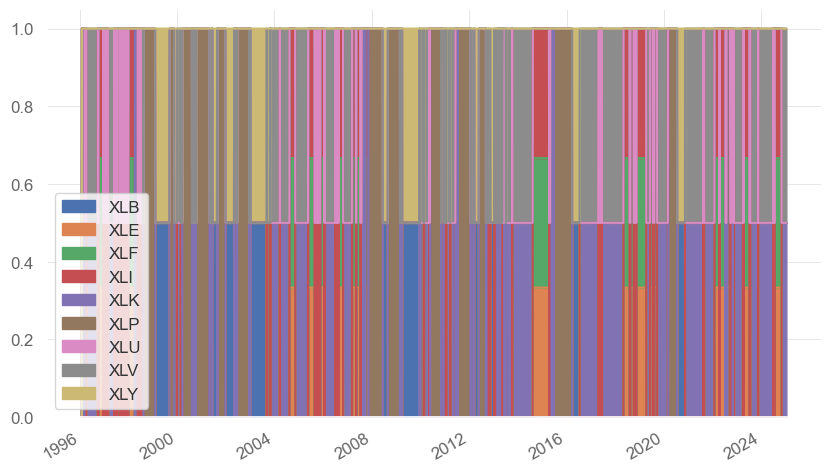

In [18]:
db.plot.area(stacked = True)

<AxesSubplot:xlabel='Date'>

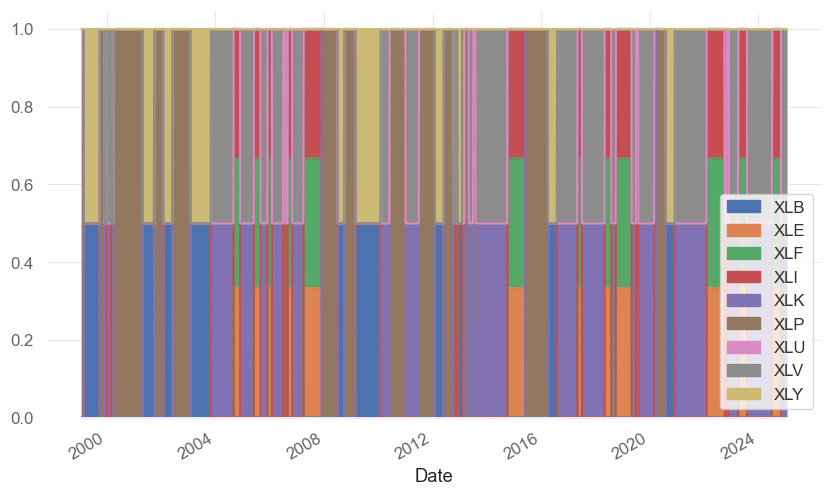

In [19]:
df_tar_m_fill.plot.area(stacked = True)


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2007-01-03  2007-01-03
End Period                 2025-01-10  2025-01-10
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          672.04%     255.44%
CAGR﹪                     12.0%       7.29%

Sharpe                     0.7         0.41
Prob. Sharpe Ratio         99.83%      95.99%
Smart Sharpe               0.64        0.38
Sortino                    0.97        0.58
Smart Sortino              0.89        0.53
Sortino/√2                 0.69        0.41
Smart Sortino/√2           0.63        0.37
Omega                      1.14        1.14

Max Drawdown               -46.78%     -59.82%
Longest DD Days            805         1813
Volatility (ann.)          18.68%      24.05%
R^2                        0.6         0.6
Information Ratio          0.01        0.01
Calmar                     0.26       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2007-10-10  2009-03-09  2009-12-23   805    -46.780495        -43.666928
2  2020-02-20  2020-03-23  2021-04-13   418    -45.436242        -40.651812
3  2018-10-04  2018-12-24  2019-10-25   386    -24.463482        -20.584371
4  2022-03-28  2022-07-14  2023-04-03   371    -17.188700        -16.316725
5  2010-01-11  2010-07-02  2010-11-04   297    -13.600866        -13.091659

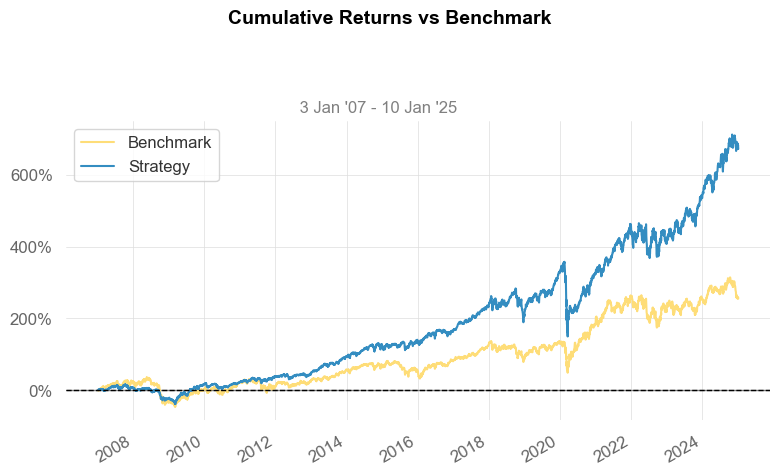

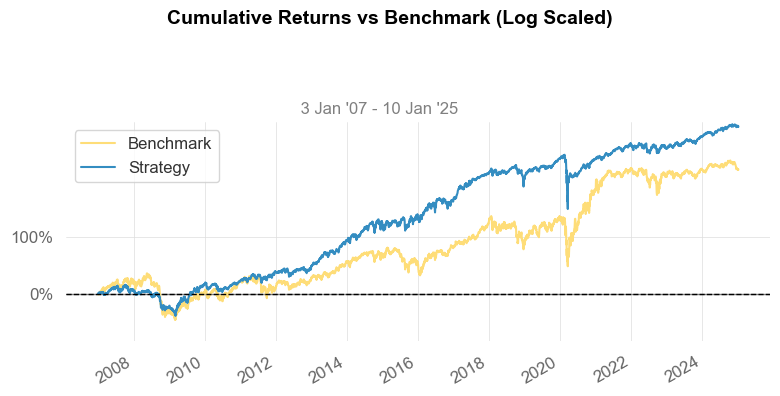

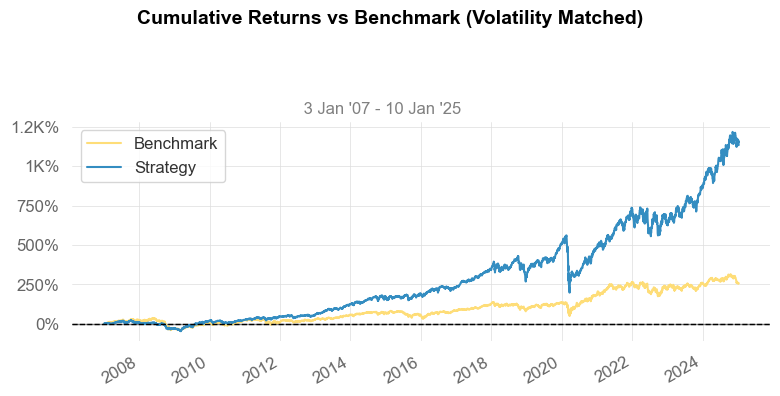

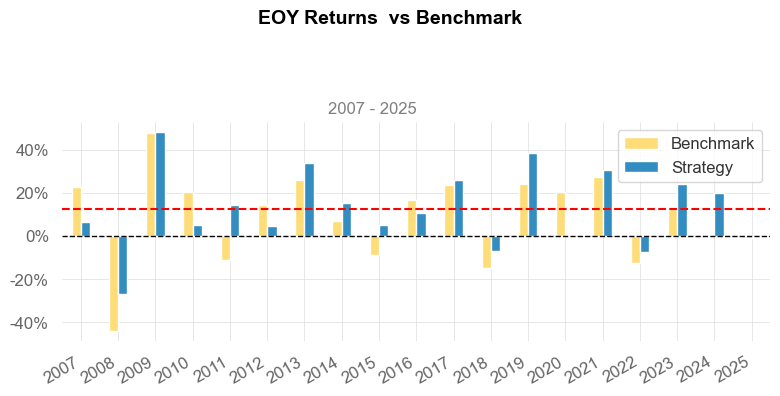

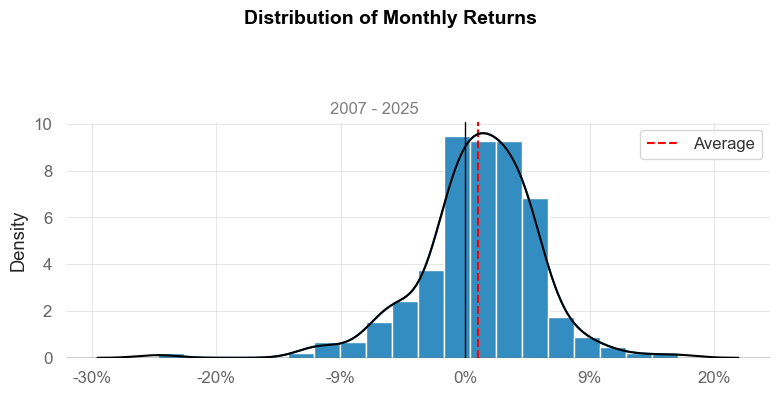

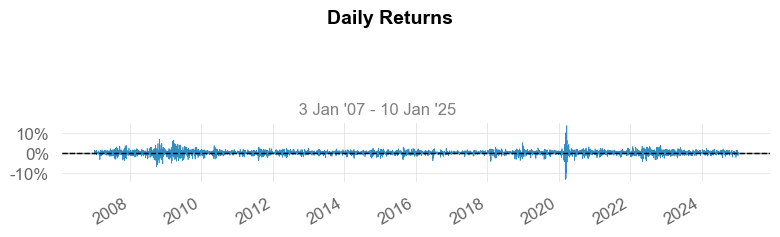

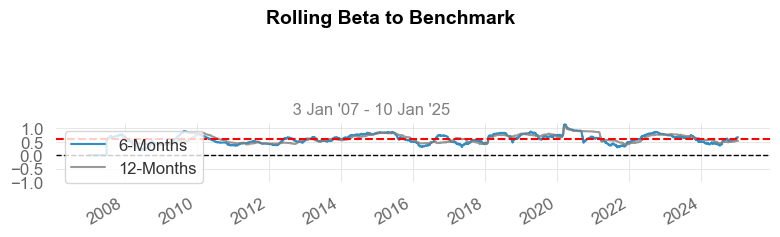

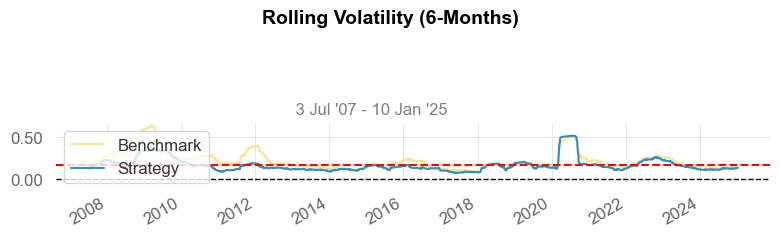

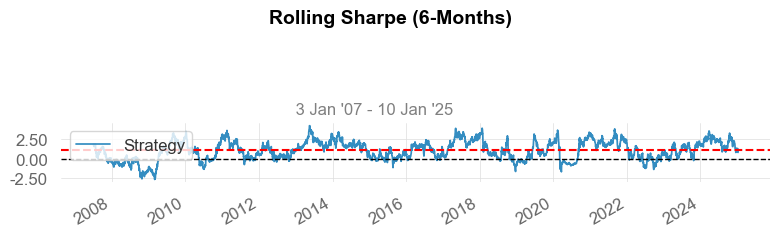

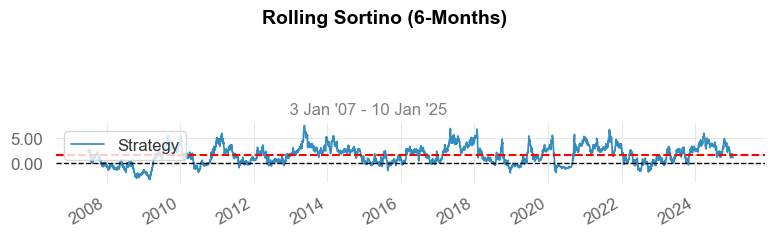

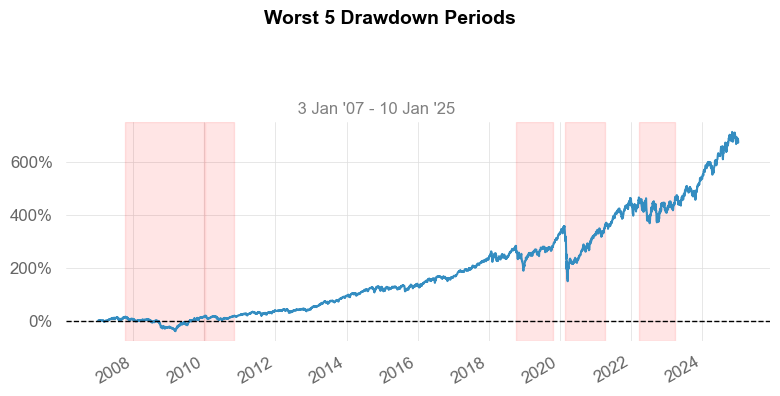

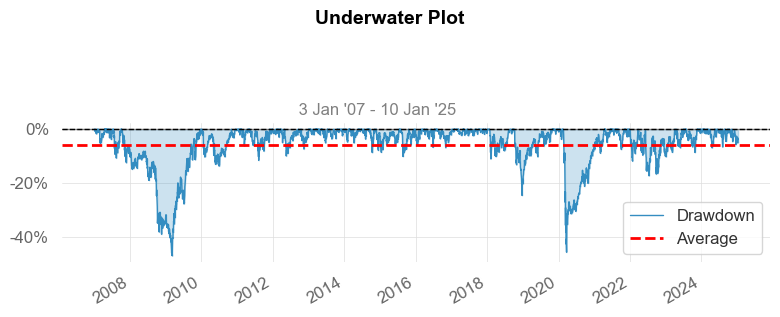

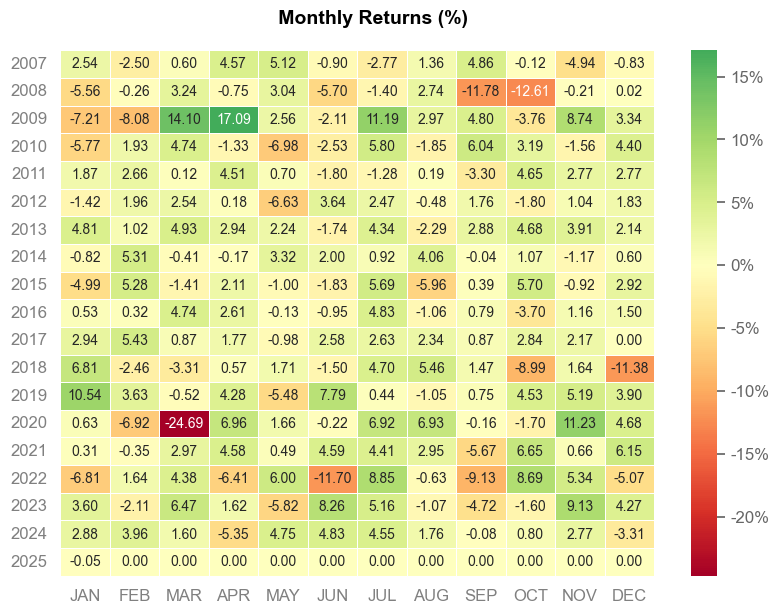

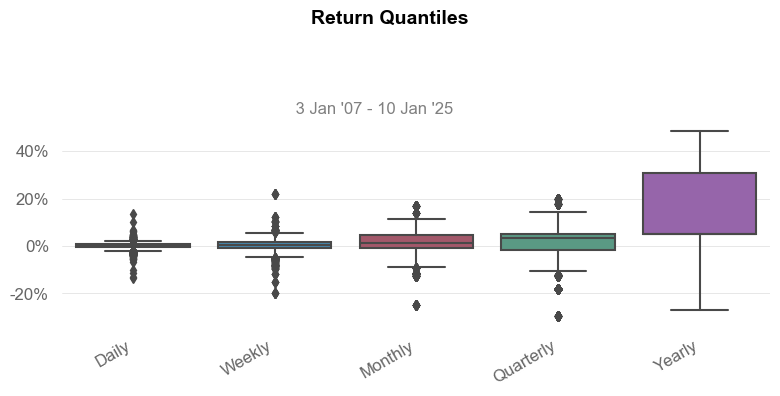

In [20]:
qs.reports.full(df_strat['2007':] , benchmark = df_return)

In [21]:
LEI_df[LEI_df['LEI(YoY)_restored']>0].mean()
LEI_df[LEI_df['LEI(YoY)_restored']<0].mean()

NameError: name 'LEI_df' is not defined